In [1]:
import numpy as np
import pandas as pd
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

#Evaluation Matrics
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

#Model selction
from sklearn.model_selection import cross_val_score, KFold,GridSearchCV

In [2]:
#load dataset
train = pd.read_csv('/content/drive/MyDrive/train.csv')
train_y = pd.read_csv('/content/drive/MyDrive/train_label.csv',header = None)
test = pd.read_csv('/content/drive/MyDrive/test.csv')
test_y = pd.read_csv('/content/drive/MyDrive/test_label.csv',header = None)
print(train.shape) 
print(train_y.shape) 
print(test.shape) 
print(test_y.shape)

(8708, 9)
(8708, 1)
(2178, 9)
(2178, 1)


In [3]:
# combining independent and dependent variables to a single dataframe for analysis.
train['Total_booking'] = train_y[0]
test['Total_booking'] = test_y[0]
print(train.shape) 
print(test.shape) 
train.head()
test.head()

(8708, 10)
(2178, 10)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking
0,5/10/2012 11:00,Summer,0,1,Clear + Few clouds,21.32,25.000,48,35.0008,256
1,6/9/2012 7:00,Summer,0,0,Clear + Few clouds,23.78,27.275,64,7.0015,87
2,3/6/2011 20:00,Spring,0,0,"Light Snow, Light Rain",11.48,12.120,100,27.9993,11
3,10/13/2011 11:00,Winter,0,1,Mist + Cloudy,25.42,28.790,83,0.0000,84
4,6/2/2012 12:00,Summer,0,0,Clear + Few clouds,25.42,31.060,43,23.9994,668


**Task-2 : 1. Feature Engineering**

In [4]:
train['datetime'] = pd.to_datetime(train['datetime'], format = '%m/%d/%Y %H:%M')
train['Day'] = train.datetime.dt.day
train['Hour'] = train.datetime.dt.hour
train['Weekday'] = train.datetime.dt.day_name()
train['Month'] = train.datetime.dt.month_name()
train['Year'] = train['datetime'].dt.year
test['datetime'] = pd.to_datetime(test['datetime'], format = '%m/%d/%Y %H:%M')
test['Day'] = test.datetime.dt.day
test['Hour'] = test.datetime.dt.hour
test['Weekday'] = test.datetime.dt.day_name()
test['Month'] = test.datetime.dt.month_name()
test['Year'] = test['datetime'].dt.year
print(train[(train['holiday']==0)&(train['workingday']==0)].head()) #checking which weekday this falls.

train[train.duplicated(['datetime'], keep=False)] # no duplicates in train
test[test.duplicated(['datetime'], keep=False)] # no duplicates in test

def day(row):
    if row['holiday'] == 1:
        return 'holiday'
    if row['workingday'] == 1:
        return 'workingday'
    if (row['holiday'] == 0)&(row['workingday'] == 0):    # this was showing for saturdays and sundays.
        return 'weekend'
train['Week_type']= train.apply(lambda row: day(row),axis=1)  #combine holiday & workingday columns in train
test['Week_type']= test.apply(lambda row: day(row),axis=1)   #combine holiday & workingday columns in test

train = train.sort_values(by=['datetime'],ascending =True).reset_index(drop=True) #sort by datetime train dataset
test = test.sort_values(by=['datetime'],ascending =True).reset_index(drop=True) #sort by datetime test dataset

del_col = ['datetime','holiday','workingday','atemp'] # Removing above interpreted columns
train.drop(del_col,axis=1,inplace=True)
test.drop(del_col,axis=1,inplace=True)
train.head()

              datetime  season  holiday  ...   Weekday     Month  Year
6  2012-10-06 09:00:00  Winter        0  ...  Saturday   October  2012
8  2012-07-14 04:00:00    Fall        0  ...  Saturday      July  2012
9  2011-02-06 18:00:00  Spring        0  ...    Sunday  February  2011
12 2011-03-13 13:00:00  Spring        0  ...    Sunday     March  2011
16 2012-10-06 11:00:00  Winter        0  ...  Saturday   October  2012

[5 rows x 15 columns]


,season,weather,temp,humidity,windspeed,Total_booking,Day,Hour,Weekday,Month,Year,Week_type
0,Spring,Clear + Few clouds,9.84,81,0.0000,16,1,0,Saturday,January,2011,weekend
1,Spring,Clear + Few clouds,9.02,80,0.0000,40,1,1,Saturday,January,2011,weekend
2,Spring,Clear + Few clouds,9.84,75,0.0000,13,1,3,Saturday,January,2011,weekend
3,Spring,Mist + Cloudy,9.84,75,6.0032,1,1,5,Saturday,January,2011,weekend
4,Spring,Clear + Few clouds,9.02,80,0.0000,2,1,6,Saturday,January,2011,weekend


**Task 1 : 3. Missing value Analysis**

In [5]:
#check for missing values 
print(train.isnull().sum())  
print(test.isnull().sum())
# No missing values

season           0
weather          0
temp             0
humidity         0
windspeed        0
Total_booking    0
Day              0
Hour             0
Weekday          0
Month            0
Year             0
Week_type        0
dtype: int64
season           0
weather          0
temp             0
humidity         0
windspeed        0
Total_booking    0
Day              0
Hour             0
Weekday          0
Month            0
Year             0
Week_type        0
dtype: int64


*No missing values in any columns.*

**Task 1: 1. Visualization of different variables**

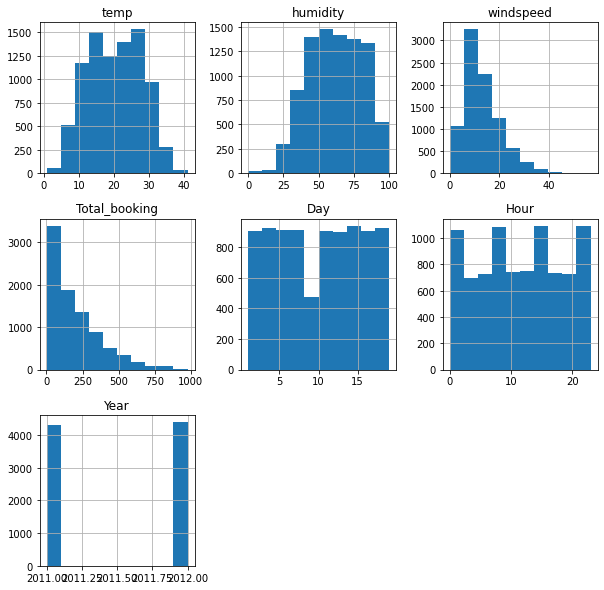

season              0
weather             0
temp                0
humidity           18
windspeed        1056
Total_booking       0
Day                 0
Hour              350
Weekday             0
Month               0
Year                0
Week_type           0
dtype: int64
              temp     humidity  ...         Hour         Year
count  8708.000000  8708.000000  ...  8708.000000  8708.000000
mean     20.243020    61.649173  ...    11.581190  2011.505168
std       7.813494    19.199578  ...     6.890534     0.500002
min       0.820000     0.000000  ...     0.000000  2011.000000
25%      13.940000    46.000000  ...     6.000000  2011.000000
50%      20.500000    61.000000  ...    12.000000  2012.000000
75%      26.240000    77.000000  ...    18.000000  2012.000000
max      41.000000   100.000000  ...    23.000000  2012.000000

[8 rows x 7 columns]


In [6]:
# check for outliers also.
train.hist(figsize=(10,10))
plt.show()
print(train.eq(0).sum()) # Hour, humidity and windspeed has '0' values. 
test.eq(0).sum()
print(train.describe())

*Hour, humidity and windspeed has '0' values. There can be outliers in windspeed and humidity. 
Windspeed can be '0' indicating 'calm'. Hour '0' means 12midnight.
Windspeed has median=12, 75%=16, but max=56.99. That can be outlier.
Total booking, humidity and windspeed shows skewness.*

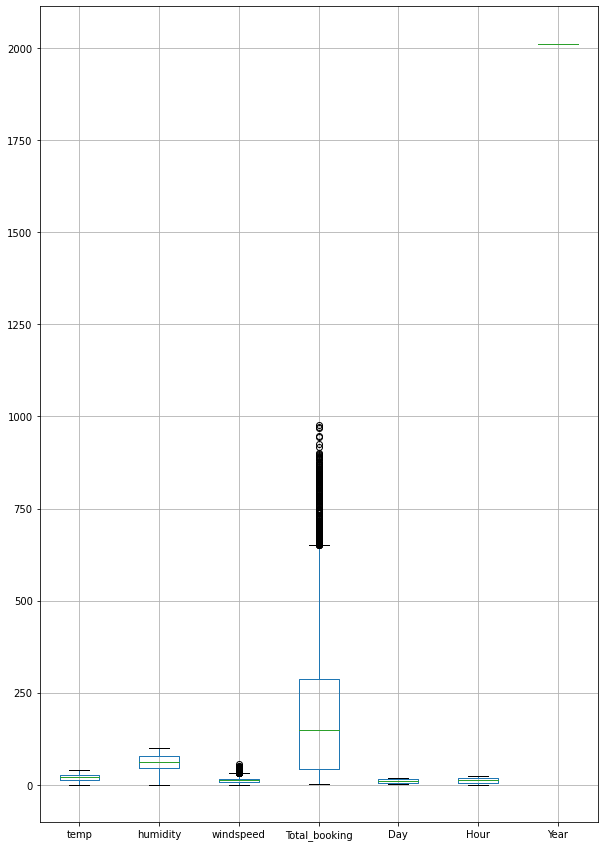

In [7]:
train.boxplot(figsize=(10,15))
plt.show()

*Windspeed and Total booking has outliers and are positively skewed.
Humidity shows negative skewness.*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


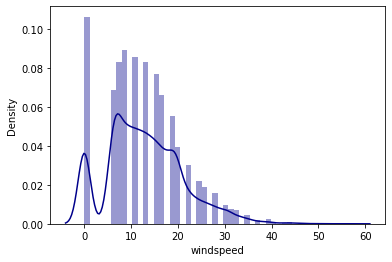

In [8]:
sns.distplot(train['windspeed'],hist=True,kde=True,color='darkblue') 

*The normal distribution curve of windspeed shows above 35 there are very little samples. They may be outliers.*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


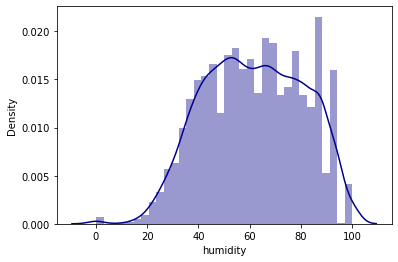

In [9]:
sns.distplot(train['humidity'],hist=True,kde=True,color='darkblue') 

*The normal distribution curve of humidity shows below 15 there are very little samples. They may be outliers.*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


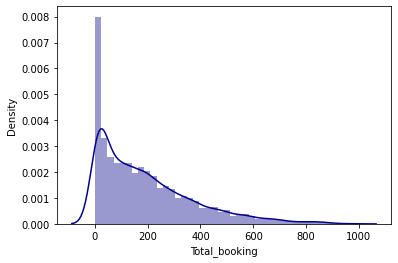

In [10]:
sns.distplot(train['Total_booking'],hist=True,kde=True,color='darkblue') 

*The normal distribution curve of Total booking shows above 800 there are very little samples. They may be outliers.*

**Task 1 : 4. Visualization Total booking Vs other features**

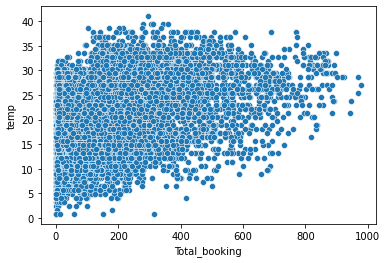

In [11]:
sns.scatterplot(x='Total_booking',y='temp',data=train)

*Total booking is maximum when temp is 31 deg celsius and also there is a positive correlation.*

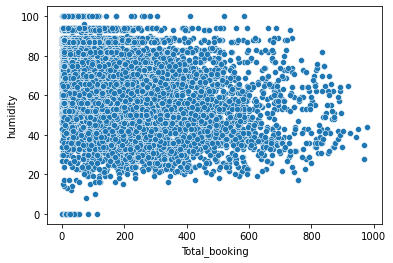

In [12]:
sns.scatterplot(x='Total_booking',y='humidity',data=train)

*Total booking is max when relative humidity is 42. 
There are few bookings at 0, min relative humidity and at 100, relative humidity. 
Both these seems to be outliers. There is negative correlation.*

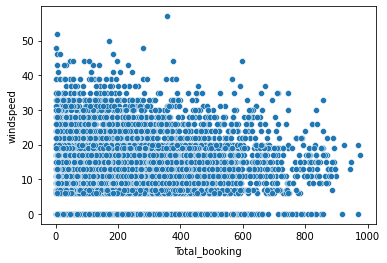

In [13]:
sns.scatterplot(x='Total_booking',y='windspeed',data=train)

*There are lot of bookings at 0 windspeed, which seems to be outliers. Maximum booking at windspeed 19.*

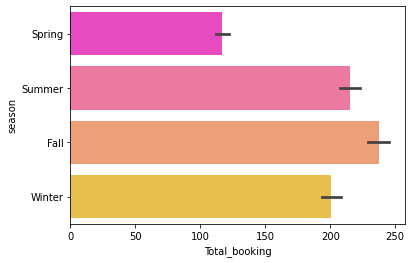

In [14]:
sns.barplot(x='Total_booking',y='season',data=train,palette='spring')

*Total booking is max during fall and min during spring.*

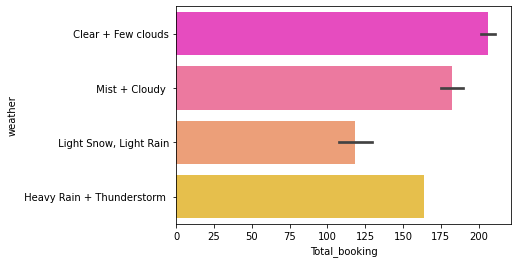

In [15]:
sns.barplot(x='Total_booking',y='weather',data=train,palette='spring')

*Total booking is max during clear, few clouds weather and min during lightsnow, light rain weather.*

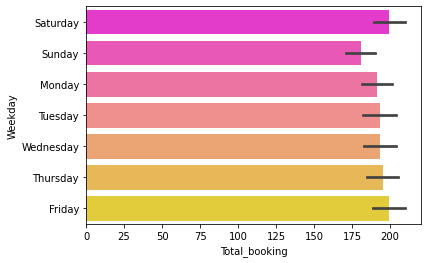

In [16]:
sns.barplot(x='Total_booking',y='Weekday',data=train,palette='spring')

*Total booking is max during Friday and Saturday. Min during Sunday and almost constant high booking during other days.*

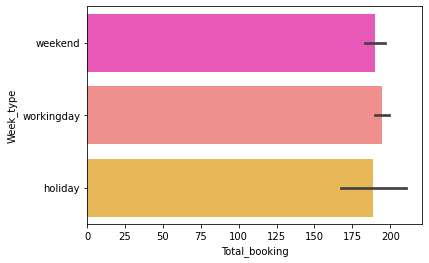

In [17]:
sns.barplot(x='Total_booking',y='Week_type',data=train,palette='spring')

*Total booking is low during holidays as compared to weekends and workingdays. No much variations with total booking.*

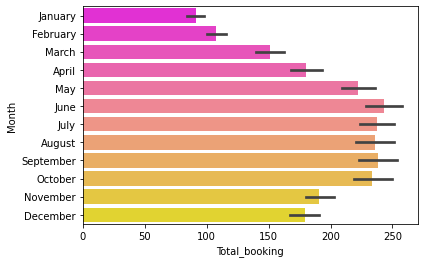

In [18]:
sns.barplot(x='Total_booking',y='Month',data=train,palette='spring')

*Total booking is max in June and min in January.*

*From the above graphs, weekdays and week_types are not showing much variations with Total booking. So they can be removed.*

**Task 1 : 2. Outlier Analysis**

*From the above plots, windspeed, humidity and total booking has outliers and skewness.*

In [19]:
train['windspeed'].skew()

0.5656111086068857

*Windspeed is positively skewed and there are outliers.*

In [20]:
train['humidity'].skew()

-0.0804110456376326

*This humidity shows left skew(negatively skewed).*

In [21]:
train['Total_booking'].skew()

1.2379281606952324

*Dependent variable is positively skewed and there are outliers.*

In [22]:
#Handling outliers
#we will slice out those outliers.
for col in ['windspeed','humidity','Total_booking']:
    percentiles = train[col].quantile([0.03,0.97]).values #Filtering 3%(0-3), 3%(97-100) extreme outlier train
    train[col] = np.clip(train[col], percentiles[0], percentiles[1])
    percentiles = test[col].quantile([0.03,0.97]).values #Filtering 3%(0-3), 3%(93-100) extreme outlier test
    test[col] = np.clip(test[col], percentiles[0], percentiles[1])

-0.004070280318262264

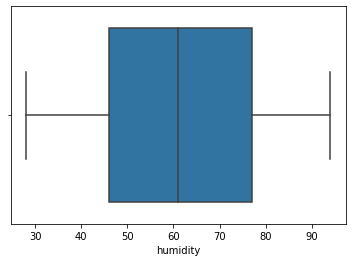

In [23]:
sns.boxplot(x=train['humidity'])
train['humidity'].skew()

*In humidity the skewness is largely removed after clipping. Its fairly symmetric.*

0.28272375454156273

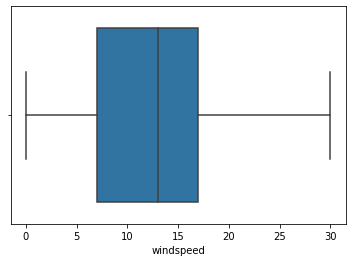

In [24]:
sns.boxplot(x=train['windspeed'])
train['windspeed'].skew()

*In windspeed the outliers are removed and skewness is also reduced. Since skewness is between 0-0.5, its fairly symmetric.*

0.979269462368779

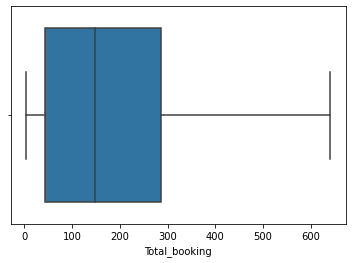

In [25]:
sns.boxplot(x=train['Total_booking'])
train['Total_booking'].skew()

*In Total booking the outliers are removed but still it is positively skewed. Since the skewness is between 0.5-1, its moderately and right skewed.*

**Task 2 : 1. Encoding catagorical features : Feature engineering(cont.)**

In [26]:
#convert categorical features into Numerical values
le=LabelEncoder()
train['season']=le.fit_transform(train['season'])
train['weather']=le.fit_transform(train['weather'])
train['Weekday']=le.fit_transform(train['Weekday'])
train['Month']=le.fit_transform(train['Month'])
train['Week_type']=le.fit_transform(train['Week_type'])
test['season']=le.fit_transform(test['season'])
test['weather']=le.fit_transform(test['weather'])
test['Weekday']=le.fit_transform(test['Weekday'])
test['Month']=le.fit_transform(test['Month'])
test['Week_type']=le.fit_transform(test['Week_type'])

**Task 1 : 5. Correlation Analysis**

                 season   weather      temp  ...     Month      Year  Week_type
season         1.000000  0.060624 -0.380153  ...  0.127627  0.000075   0.007321
weather        0.060624  1.000000 -0.058179  ...  0.022890  0.009158   0.011775
temp          -0.380153 -0.058179  1.000000  ...  0.118058  0.066451   0.028225
humidity       0.059757  0.340343 -0.066724  ...  0.138954 -0.078342  -0.005014
windspeed     -0.004037 -0.028389 -0.022756  ... -0.050791 -0.016592   0.010076
Total_booking -0.004319 -0.082921  0.402536  ...  0.094149  0.262822   0.003571
Day           -0.002072  0.007569  0.024511  ... -0.006460 -0.001171   0.020446
Hour          -0.002062 -0.046267  0.146668  ...  0.001407  0.005712   0.000318
Weekday       -0.008154  0.036442  0.022367  ...  0.000633  0.014183   0.227931
Month          0.127627  0.022890  0.118058  ...  1.000000  0.011084  -0.027614
Year           0.000075  0.009158  0.066451  ...  0.011084  1.000000  -0.009626
Week_type      0.007321  0.011775  0.028

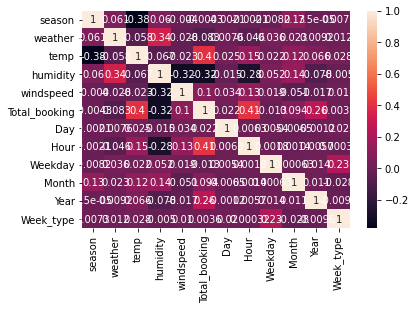

In [27]:
# Correlation analysis
correlation=train.corr()
print(correlation)
sns.heatmap(correlation,annot=True)

*With Total booking : temp, hour and Year shows good positive correlation. Humidity shows good negative correlation. Season,weekday,day and week_type has very low correlation. Windspeed,month and weather has low correlation.*

*Season has good negative correlation with temp. Weather has good positive correlation with humidity. Windspeed has good negative correlation with humidity. Hence independent features like temp, humidity, Year, Month and hour can be considered for model.**

*Considering the right skew in windspeed, good negative colinearity with humidity and also low correlation with total booking, windspeed column can be removed.*

**Task 2 : 1. Feature Engineering (cont.)**

In [28]:
train=train[['temp','humidity','Hour','Month','Year','Total_booking']]
test =test[['temp','humidity','Hour','Month','Year','Total_booking']]

In [29]:
#scaling
scaler = StandardScaler()
train_columns = train.columns
train = scaler.fit_transform(train)
train = pd.DataFrame(train)
train.columns = train_columns
test_columns = test.columns
test = scaler.fit_transform(test)
test = pd.DataFrame(test)
test.columns = test_columns
train.head()

,temp,humidity,Hour,Month,Year,Total_booking
0,-1.331494,1.030771,-1.680836,-0.431667,-1.010389,-1.010688
1,-1.436446,0.977201,-1.535701,-0.431667,-1.010389,-0.871210
2,-1.331494,0.709355,-1.245431,-0.431667,-1.010389,-1.028123
3,-1.331494,0.709355,-0.955161,-0.431667,-1.010389,-1.086238
4,-1.436446,0.977201,-0.810026,-0.431667,-1.010389,-1.086238


In [30]:
#Spliting the independent and dependent features.
X_train = train.drop(['Total_booking'],axis=1)
y_train = train['Total_booking']
X_test = test.drop(['Total_booking'],axis=1)
y_test = test['Total_booking']

**Task 2: 2. Grid Search for Regression Models**

In [31]:
#Gridsearchcv
# 1. Linear regression
model = LinearRegression()
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
parameters = {'fit_intercept':[True,False],'normalize':[True,False],'copy_X':[True,False]}
grid = GridSearchCV(model,param_grid=parameters,cv=kfold,n_jobs = None)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print('Best score : ',grid.best_score_)
print('Accuracy(test) : ',grid.score(X_test,y_test))
predicted = grid.predict(X_test)
print('Mean squared error : %.2f'%np.mean((predicted-y_test)**2))

{'copy_X': True, 'fit_intercept': False, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
Best score :  0.3860699107247466
Accuracy(test) :  0.39310969847460275
Mean squared error : 0.61


*Linear regression model has 39% Accuracy.*

In [32]:
# 2. Ridge
model = Ridge()
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
parameters = {'alpha' : [1,0.1,0.01,0.001,0.0001,0],'fit_intercept':[True,False]} 
grid = GridSearchCV(model,param_grid = parameters,cv=kfold)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print('Best score : ',grid.best_score_)
print('Accuracy(test) : ',grid.score(X_test,y_test))
predicted = grid.predict(X_test)
print('Mean squared error : %.2f'%np.mean((predicted-y_test)**2))

{'alpha': 1, 'fit_intercept': False}
Ridge(alpha=1, copy_X=True, fit_intercept=False, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
Best score :  0.38606994998531297
Accuracy(test) :  0.3931083793554836
Mean squared error : 0.61


*Ridge regression model has 39% accuracy.*

In [33]:
# 3. Lasso
parameters = {'alpha': (np.logspace(-8, 8, 100))} # It will check from 1e-08 to 1e+08
model = Lasso(normalize=True)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(model, parameters, cv = kfold)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print('Best score : ',grid.best_score_)
print('Accuracy(test) : ',grid.score(X_test,y_test))
predicted = grid.predict(X_test)
print('Mean squared error : %.2f'%np.mean((predicted-y_test)**2))

{'alpha': 6.42807311728432e-08}
Lasso(alpha=6.42807311728432e-08, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Best score :  0.38598490463051666
Accuracy(test) :  0.39310934531601505
Mean squared error : 0.61



*Lasso regression model has 39% accuracy.*


In [34]:
# KNeighborsRegressor
model = KNeighborsRegressor()
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
params_knn = {'n_neighbors':[5,6,7,8,9,10], 'leaf_size':[1,2,3,5],
              'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree','kd_tree','brute']}
grid = GridSearchCV(model, param_grid=params_knn, cv=kfold, scoring='r2')
grid.fit(X_train, y_train)
print(grid.best_estimator_)
print(grid.best_params_)
print('Best score : ',grid.best_score_)
print('Accuracy(test) : ',grid.score(X_test,y_test))
predicted = grid.predict(X_test)
print('Mean squared error : %.2f'%np.mean((predicted-y_test)**2))

KNeighborsRegressor(algorithm='brute', leaf_size=1, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
{'algorithm': 'brute', 'leaf_size': 1, 'n_neighbors': 5, 'weights': 'uniform'}
Best score :  0.7082537413731625
Accuracy(test) :  0.7127609781190113
Mean squared error : 0.29


*KNeighbour regressor has 71% accuracy.*

In [35]:
DTR = DecisionTreeRegressor()
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
         'max_depth':[2,3,4,5,6,7,8]}
grid = GridSearchCV(DTR, param_grid=params,cv=kfold)
grid.fit(X_train, y_train)
print(grid.best_estimator_)
print(grid.best_params_)
print('Best score : ',grid.best_score_)
print('Accuracy(test) : ',grid.score(X_test,y_test))
predicted = grid.predict(X_test)
print('Mean squared error : %.2f'%np.mean((predicted-y_test)**2))

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=9, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
{'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 9, 'min_samples_split': 3}
Best score :  0.7232489681111165
Accuracy(test) :  0.7189485163858687
Mean squared error : 0.28


*Decision Tree regressor model has 72% accuracy.*

In [42]:
# SVR
#parameters = {'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
parameters = {'C':[1.5, 10],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale'),'epsilon':[0.1,0.2,0.5,0.3]}
modelsvr = SVR()
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(estimator = modelsvr, param_grid = parameters, cv=kfold, n_jobs = 8) 
grid.fit(X_train,y_train)
print(grid.best_estimator_)
print(grid.best_params_)
print('Best score : ',grid.best_score_)
print('Accuracy(test) : ',grid.score(X_test,y_test))
predicted = grid.predict(X_test)
print('Mean squared error : %.2f'%np.mean((predicted-y_test)**2))

SVR(C=10, cache_size=200, coef0=0.01, degree=3, epsilon=0.5, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
{'C': 10, 'coef0': 0.01, 'epsilon': 0.5, 'gamma': 'scale'}
Best score :  0.6259062150137396
Accuracy(test) :  0.6287187637873319
Mean squared error : 0.37


*SVR model has an Accuracy of 63%.*

**Task 2 : 3. Regression Analysis**

In [44]:
#Regression 
models = []
models.append(('lr',LinearRegression(copy_X= True, fit_intercept= False, normalize= True)))
models.append(('ridge',Ridge(alpha= 1, fit_intercept= False)))
models.append(('ridgecv',RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])))
models.append(('lasso',Lasso(alpha= 6.42807311728432e-08)))
models.append(('svm',SVR(C= 10, coef0= 0.01, epsilon= 0.5, gamma= 'scale')))
models.append(('knn',KNeighborsRegressor(algorithm= 'brute', leaf_size= 1, n_neighbors= 5, weights= 'uniform')))
models.append(('DTR',DecisionTreeRegressor(max_depth= 8, max_features= 'auto', min_samples_leaf= 9, min_samples_split= 5)))

for name,model in models:
    kfold=KFold(n_splits=5,random_state=0,shuffle=True) 
    scores = cross_val_score(model,X_train,y_train,cv=kfold)
    print('{} : Train_Accuracy: {} (standard deviation: {})'.format(name,scores.mean(),scores.std()))
    model.fit(X_train,y_train)
    predicted = model.predict(X_test)
    print('Mean squared error:%.2f'%mean_squared_error(y_test,predicted))
    print('Mean absolute error:%.2f'%mean_absolute_error(y_test,predicted))
    print('Variance score:%.2f'%r2_score(y_test,predicted))
    

lr : Train_Accuracy: 0.3860699107247466 (standard deviation: 0.01072114657695598)
Mean squared error:0.61
Mean absolute error:0.60
Variance score:0.39
ridge : Train_Accuracy: 0.38606994998531297 (standard deviation: 0.010719699020026592)
Mean squared error:0.61
Mean absolute error:0.60
Variance score:0.39
ridgecv : Train_Accuracy: 0.3859849380226721 (standard deviation: 0.010712125376387145)
Mean squared error:0.61
Mean absolute error:0.60
Variance score:0.39
lasso : Train_Accuracy: 0.3859849044265064 (standard deviation: 0.010713563020862555)
Mean squared error:0.61
Mean absolute error:0.60
Variance score:0.39
svm : Train_Accuracy: 0.6259062150137396 (standard deviation: 0.007314499958796205)
Mean squared error:0.37
Mean absolute error:0.45
Variance score:0.63
knn : Train_Accuracy: 0.7082537413731625 (standard deviation: 0.008919716578314144)
Mean squared error:0.29
Mean absolute error:0.36
Variance score:0.71
DTR : Train_Accuracy: 0.7232482370087241 (standard deviation: 0.00424940163

*Above analysis on different regression models shows **Decision Tree Regressor** model has highest Accuracy score of **72%**.*


**Task 2 : 4 Gridsearchcv for Ensemble Models**

In [45]:
# Random Forest Regressor
params = {"max_depth": [3,5,6,7,8,9],
              "max_features":['auto', 'sqrt', 'log2'],
              "min_samples_split": [2, 3,5,7],
              "min_samples_leaf": [1, 3,5,6],
            "bootstrap": [True, False],
          "n_estimators" : [10,20,30]}
forest_reg=RandomForestRegressor(random_state=0)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
grid=GridSearchCV(forest_reg,params,cv=kfold,n_jobs=-1)
grid.fit(X_train,y_train)
print(grid.best_estimator_)
print(grid.best_params_)
print('Best score : ',grid.best_score_)
print('Accuracy(test) : ',grid.score(X_test,y_test))
predicted = grid.predict(X_test)
print('Mean squared error : %.2f'%np.mean((predicted-y_test)**2))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=6,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)
{'bootstrap': True, 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 30}
Best score :  0.7580914745195819
Accuracy(test) :  0.7489373697256889
Mean squared error : 0.25


*Random Forest Regressor has Accuracy/mean crossvalidation score of 76% with 0.25 mean square error and test accuracy of 75%.*

In [46]:
# Gradiant Boosting Regressor
gbrt=GradientBoostingRegressor()
params_GBR_GS = {"max_depth": [3,5,6,7],
              "max_features":['auto', 'sqrt', 'log2'],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
            'learning_rate':[0.05,0.1,0.2],
            'n_estimators': [10,30,50,70]}
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
grid=GridSearchCV(gbrt,param_grid=params_GBR_GS,cv=kfold)
grid.fit(X_train,y_train)
print(grid.best_estimator_)
print(grid.best_params_)
print('Best score : ',grid.best_score_)
print('Accuracy(test) : ',grid.score(X_test,y_test))
predicted = grid.predict(X_test)
print('Mean squared error : %.2f'%np.mean((predicted-y_test)**2))

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=6,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=70,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
{'learning_rate': 0.1, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
Best score :  0.7774581324033565
Accuracy(test) :  0.7590965693672354
Mean squared error : 0.24


*GradientBoosting Regressor has Accuracy/mean crossvalidation score of 78% with 0.24 mean squared error and test accuracy of 76%.*

In [47]:
# Bagging Regressor
model = BaggingRegressor()
params_bag_GS = {"n_estimators": [50,100,200],
              "max_features":[1,2,4,6,8],
              "max_samples": [0.5,0.1],
            "bootstrap": [True, False],
         "bootstrap_features": [True, False]}
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(estimator= model, param_grid= params_bag_GS, cv=kfold, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_estimator_)
print(grid.best_params_)
print('Best score : ',grid.best_score_)
print('Accuracy(test) : ',grid.score(X_test,y_test))
predicted = grid.predict(X_test)
print('Mean squared error : %.2f'%np.mean((predicted-y_test)**2))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=4, max_samples=0.5, n_estimators=100, n_jobs=None,
                 oob_score=False, random_state=None, verbose=0,
                 warm_start=False)
{'bootstrap': True, 'bootstrap_features': False, 'max_features': 4, 'max_samples': 0.5, 'n_estimators': 100}
Best score :  0.7530422548175922
Accuracy(test) :  0.732102173985962
Mean squared error : 0.27


*BaggingRegressor has Accuracy/mean crossvalidation score of 75% with 0.27 mean square error and test accuracy of 73%.*

In [48]:
# Adaboost Regressor
AdaBoost = AdaBoostRegressor()
params_AdbR_GS = {'learning_rate':[0.05,0.1,0.2,0.6,0.8,1], 'n_estimators': [50,60,100],
                 'loss' : ['linear', 'square', 'exponential']}
kfold = KFold(n_splits=5, shuffle=True, random_state=0)                 
grid = GridSearchCV(AdaBoost, param_grid=params_AdbR_GS,cv=kfold)
grid.fit(X_train, y_train)
print(grid.best_estimator_)
print(grid.best_params_)
print('Best score : ',grid.best_score_)
print('Accuracy(test) : ',grid.score(X_test,y_test))
predicted = grid.predict(X_test)
print('Mean squared error : %.2f'%np.mean((predicted-y_test)**2))

AdaBoostRegressor(base_estimator=None, learning_rate=1, loss='linear',
                  n_estimators=60, random_state=None)
{'learning_rate': 1, 'loss': 'linear', 'n_estimators': 60}
Best score :  0.6246466718746426
Accuracy(test) :  0.6369090007794074
Mean squared error : 0.36


*AdaboostRegressor has Accuracy/mean crossvalidation score of 62% with 0.36 mean square error and test accuracy of 63%.*

**Synopsis:**

*In order to forcast the cab booking demand in the city, above analysis is performed on the data provided. Finally the best model with optimum parameters is selected. **GradientBoosting Regressor** is the model and has Accuracy/mean crossvalidation score of 78% with 0.24 mean squared error and test accuracy of 76%.*